In [63]:
import json
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import matplotlib.pyplot as plt
import time

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

cuda


In [78]:
with open('Datasets/processed_dataset.json', 'r') as f:
    data = json.load(f)

# Получение текста и рейтинга
texts = [entry['text'] for entry in data]
ratings = [entry['rating'] - 1 for entry in data]

In [66]:
X_train, y_train = texts[:8000], ratings[:8000]
X_test, y_test = texts[8000:], ratings[8000:]
print(len(X_train), len(X_test))

8000 2000


In [67]:
# Создание токенизатора для модели BERT
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Токенизация текстов
tokenized_texts = tokenizer(X_train, padding='max_length', truncation=True, return_tensors='pt')

# Получение токенизированных текстов
input_ids = tokenized_texts['input_ids']


In [68]:
# Создание класса Dataset
class TextDataset(Dataset):
    def __init__(self, input_ids, ratings):
        self.input_ids = input_ids
        self.ratings = torch.tensor(ratings, dtype=torch.long)

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.ratings[idx]


In [69]:
# Создание объекта Dataset
dataset = TextDataset(input_ids, y_train)

# Создание DataLoader
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Определение размеров словаря и эмбеддингов
vocabulaire_size2 = tokenizer.vocab_size
embedding_dim = 128
print(vocabulaire_size2)

30522


In [70]:
class LSTM_model(nn.Module):
    def __init__(self, vocabulaire_size2, embedding_dim, hidden_size1=128, hidden_size2=64):
        super(LSTM_model, self).__init__()
        self.embedding = nn.Embedding(vocabulaire_size2, embedding_dim)
        
        self.lstm1 = nn.LSTM(embedding_dim, hidden_size1, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size1 * 2, hidden_size2, bidirectional=True, batch_first=True)
        
        self.dropout = nn.Dropout(0.2)
        
        self.dense = nn.Linear(hidden_size2 * 2, 5) # Выходной слой для 5 классов рейтинга
        self.softmax = nn.Softmax(dim=1)

        # Инициализация весов
        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.lstm1.weight_ih_l0)
        nn.init.xavier_uniform_(self.lstm1.weight_hh_l0)
        nn.init.xavier_uniform_(self.lstm2.weight_ih_l0)
        nn.init.xavier_uniform_(self.lstm2.weight_hh_l0)
        nn.init.xavier_uniform_(self.dense.weight)
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x = x[:, -1, :]  # Используем только последний hidden state
        x = self.dropout(x)
        x = self.dense(x)
        x = self.softmax(x)
        return x

In [71]:
model = LSTM_model(vocabulaire_size2, embedding_dim)
model.to(device)

LSTM_model(
  (embedding): Embedding(30522, 128)
  (lstm1): LSTM(128, 128, batch_first=True, bidirectional=True)
  (lstm2): LSTM(256, 64, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (dense): Linear(in_features=128, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)

In [72]:
optimizer = torch.optim.SGD(model.parameters())
criterion = nn.CrossEntropyLoss()

In [73]:
def train_model(model, dataloader, optimizer, criterion, epochs=10):
    
    loss_history = np.zeros(epochs)
    acc_history = np.zeros(epochs)
    
    start_time = time.time()
    
    for epoch in range(epochs):
        
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(dataloader):  # Используем enumerate
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()

            outputs = model(data)

            loss = criterion(outputs, target)
            loss.backward()

            optimizer.step()


            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        epoch_loss = running_loss/len(dataloader)
        epoch_accuracy = correct/total
        
        loss_history[epoch] = epoch_loss
        acc_history[epoch] = epoch_accuracy
        
        print(f'Epoch {epoch+1} | Loss: {running_loss/len(dataloader):.4f} | Accuracy: {epoch_accuracy}')
    
    print(f"Training time: {time.time() - start_time} seconds")
    print(f"Final acc: {epoch_accuracy}")
    print(f"Loss delta: {loss_history[0] - epoch_loss}")
    
    plt.plot(loss_history, label="Loss")
    plt.plot(acc_history, label="Accuracy")
    plt.xlabel("Epoch")

    plt.legend()

    plt.savefig("Plots/LSTM_loss.png")
    
    
def evaluate(model, val_loader):
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            
            predicted = torch.round(output.squeeze())
            correct += (predicted == target).sum().item()
            total += target.size(0)
        
        accuracy = correct / total
    
    return accuracy

Epoch 1 | Loss: 1.6149 | Accuracy: 0.11225
Epoch 2 | Loss: 1.6144 | Accuracy: 0.1195
Epoch 3 | Loss: 1.6138 | Accuracy: 0.122625
Epoch 4 | Loss: 1.6132 | Accuracy: 0.1285
Epoch 5 | Loss: 1.6127 | Accuracy: 0.134375
Epoch 6 | Loss: 1.6121 | Accuracy: 0.14725
Epoch 7 | Loss: 1.6115 | Accuracy: 0.153625
Epoch 8 | Loss: 1.6109 | Accuracy: 0.1665
Epoch 9 | Loss: 1.6105 | Accuracy: 0.174375
Epoch 10 | Loss: 1.6098 | Accuracy: 0.197625
Epoch 11 | Loss: 1.6096 | Accuracy: 0.204125
Epoch 12 | Loss: 1.6087 | Accuracy: 0.22625
Epoch 13 | Loss: 1.6082 | Accuracy: 0.2405
Epoch 14 | Loss: 1.6077 | Accuracy: 0.252375
Epoch 15 | Loss: 1.6070 | Accuracy: 0.269
Epoch 16 | Loss: 1.6063 | Accuracy: 0.291375
Epoch 17 | Loss: 1.6058 | Accuracy: 0.309625
Epoch 18 | Loss: 1.6054 | Accuracy: 0.316625
Epoch 19 | Loss: 1.6047 | Accuracy: 0.33575
Epoch 20 | Loss: 1.6040 | Accuracy: 0.352
Epoch 21 | Loss: 1.6035 | Accuracy: 0.361625
Epoch 22 | Loss: 1.6029 | Accuracy: 0.370125
Epoch 23 | Loss: 1.6025 | Accuracy: 0

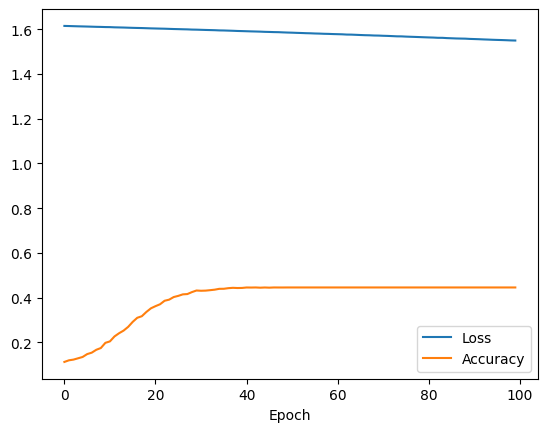

In [74]:
train_model(model, dataloader, optimizer, criterion, epochs=100)
torch.save(model.state_dict(), 'LSTM_model.pth')

In [75]:
texts = X_test
ratings = y_test

In [76]:
def predict(text, rating):
    inputs = tokenizer(text, padding='max_length', truncation=True, return_tensors='pt')

    inputs = inputs.to(device)

    with torch.no_grad():
        outputs = model(inputs['input_ids'])
        predicted_rating = torch.argmax(outputs).item()

    return predicted_rating

In [77]:
total = 0
correct = 0

for i in range(len(texts)):
    pred = predict(texts[i], ratings[i])
    
    correct += (pred == ratings[i])
    total += 1
    
print(correct/total)

0.4415
